In [73]:
from nltk.corpus import stopwords
import pandas as pd
import nltk
import re
import unicodedata
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from nltk import word_tokenize
import preprocessor.api as p
import matplotlib.pyplot as plt

data = pd.read_csv('2018_food_clean.csv')

In [74]:
clean = []
for i,v in enumerate(data['captions']):
    temp = p.clean(str(v))
    clean.append(temp)
data['clean'] = clean

stoplist = stopwords.words('english')
stoplist.extend(['link', 'bio', 'foodstagram', 'foodblogger',
                   'foodblogger', 'travelblogger', 'tag', 'picoftheday',
                   'instadaily', 'like', 'follow', 'discount', 'game',
                   'tsp', 'tbsp', '[', ']', 'na', 'teaspoon', 'get', 'us'
                   'food', 'time', 'recipe', 'de', 'well', 'little', 'love',
                   'make', 'day', 'order', 'today', 'delivery', 'dinner', 'meal'
                   'im', 'dont', 'try', 'sunday', 'need', 'ingredients', 'saturday'
                   'weekend', 'place', 'want', 'think', 'lunch', 'bowl', 'dish',
                   'help', 'perfect', 'week', 'home', 'post', "'i'm", 'cup', 'travel',
                   'travelphotography', 'follow4follow', 'travelphotography', 'travelgramsky'
                   'instafollow', 'instagood', 'followme', 'bestoftheday', 'smile', 'instalike',
                   'foodlover', 'let', 'know', 'like4like', 'clevelandohio', 'new', 'latino'])

In [53]:
c_vec = CountVectorizer(stop_words=stoplist, ngram_range=(2,2))
# matrix of ngrams
ngrams = c_vec.fit_transform(data['clean'].values.astype('U'))
# count frequency of ngrams
count_values = ngrams.toarray().sum(axis=0)
# list of ngrams.
vocab = c_vec.vocabulary_

data_ngram = pd.DataFrame(sorted([(count_values[i], k) for k, i in vocab.items()], reverse=True)).rename(columns={0: 'frequency', 1: 'bigram'})

In [75]:
def basic_clean(text):
  """
  A simple function to clean up the data. All the words that
  are not designated as a stop word is then lemmatized after
  encoding and basic regex parsing are performed.
  """
  wnl = nltk.stem.WordNetLemmatizer()
  text = (unicodedata.normalize('NFKD', text)
    .encode('ascii', 'ignore')
    .decode('utf-8', 'ignore')
    .lower())
  words = re.sub(r'[^\w\s]', '', text).split()
  return [wnl.lemmatize(word) for word in words if word not in stoplist]

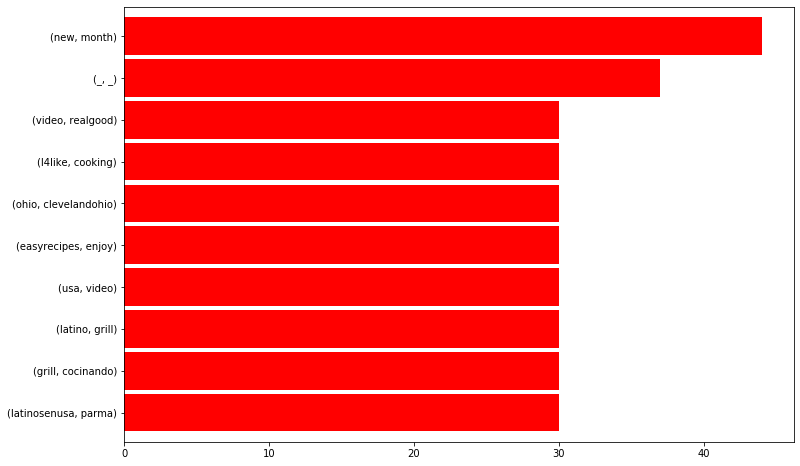

In [77]:
words = basic_clean(''.join(str(data['clean'].tolist())))
bigram_series = (pd.Series(nltk.ngrams(words, 2)).value_counts())[:10]

bigram_series.sort_values().plot.barh(color='red', width=0.9, figsize=(12,8))

In [54]:
print(bigram_series.head(12))

0                        olive oil
1                      salt pepper
2                   meat meatlover
3     healthylifestyle healthyfood
4              healthyfood healthy
5                     sweet potato
6     healthyfood healthylifestyle
7              healthy healthyfood
8                      gluten free
9                   like4like look
10                instafollow girl
11               amazing like4like
Name: bigram, dtype: object


In [78]:
data_ngram['polarity'] = data_ngram['bigram/trigram'].apply(lambda x: TextBlob(x).polarity)
data_ngram['subjective'] = data_ngram['bigram/trigram'].apply(lambda x: TextBlob(x).subjectivity)

In [36]:
print(data_ngram)

        frequency                 bigram/trigram  polarity  subjective
0             227                    balam xelha       0.0    0.000000
1             222                     xelha yuki       0.0    0.000000
2             215               balam xelha yuki       0.0    0.000000
3             208    petsofworld petsofinstagram       0.0    0.000000
4             208  pawprints animallover pawclub       0.0    0.000000
...           ...                            ...       ...         ...
110865          1              02032021 crossfit       0.0    0.000000
110866          1               01376 340 307408       0.0    0.000000
110867          1                      01376 340       0.0    0.000000
110868          1                  0000 eet last       0.0    0.066667
110869          1                       0000 eet       0.0    0.000000

[110870 rows x 4 columns]


In [84]:
'''Builds a LDA model'''

tfidf_vectorizer = TfidfVectorizer(stop_words=stoplist, ngram_range=(2,3))
lda = LatentDirichletAllocation(n_components=3)
pipe = make_pipeline(tfidf_vectorizer, lda)
pipe.fit(data['captions'].values.astype('U'))

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " %topic_idx
        message += ", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()
    
print_top_words(lda, tfidf_vectorizer.get_feature_names(), n_top_words=3)

Topic #0: petlover peekitos pawprints, mexipets mykidshavepaws lovemyfurfriends, petlover peekitos
Topic #1: teamtrufita teambibrisas, healthypets mexicanpets, petlover pawprints animallover
Topic #2: nogamenolife jibril, tagsignore shirosorashirosora, jibril stephlove



In [80]:
tfidf = TfidfVectorizer(stop_words=stoplist, ngram_range=(2,3))
tfidfngrams = tfidf.fit_transform(data['captions'].values.astype('U')) 
tfidf_val = tfidfngrams.sum(axis=0)
data1 = []
for col, term in enumerate(c_vec.get_feature_names()):
    data1.append((term, tfidf_val[0,col]))
ranking = pd.DataFrame(data1, columns= ['term', 'rank']).sort_values('rank', ascending=False)
ranking.to_csv('2018_companies_tfidf.csv')

In [81]:
data_ngram.to_csv('2018_companies_ngrams.csv', index=False)